In [3]:
import os
import cv2 
import etl.modules.equi2perspec as E2P 
import matplotlib.pyplot as plt

In [8]:
equ = E2P.Equirectangular('data/images/__7RwCSRHYUHVB9kOP1sXQ.jpeg')    # Load equirectangular image

#
# FOV unit is degree 
# theta is z-axis angle(right direction is positive, left direction is negative)
# phi is y-axis angle(up direction positive, down direction negative)
# height and width is output image dimension 
#
img = equ.GetPerspective(60, 0, 0, 720, 1440) # Specify parameters(FOV, theta, phi, height, width)

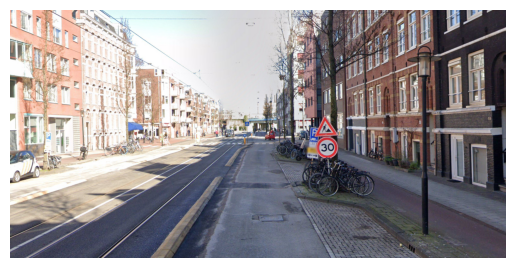

In [9]:
# Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axes
plt.show()